In [19]:
#ALGORITHM = 'XG Boost'
#ALGORITHM = 'Linear Regression (Ridge)'
ALGORITHM = 'KNN'
#ALGORITHM = 'Decision Tree'
#ALGORITHM = 'Random Forest'
#ALGORITHM = 'CatBoost'
#ALGORITHM = 'Light Gradient Boosting'

ALGORITHM_DETAIL = 'random search'
DATA_DETAIL = []
#DATA_DETAIL = ['explore param']
#DATA_DETAIL = ['no scale','no dummies']
#DATA_DETAIL = ['no dummies']
VERSION = '06'

RANDOM_STATE = 101
TRAINING_SIZE = 0.9

CROSS_VALIDATION_SCORING = 'r2'

print(f'ALGORITHM: {ALGORITHM}')
print(f'ALGORITHM_DETAIL: {ALGORITHM_DETAIL}')
print(f'DATA_DETAIL: {DATA_DETAIL}')
print(f'DATA VERSION: {VERSION}')


ALGORITHM: KNN
ALGORITHM_DETAIL: random search
DATA_DETAIL: []
DATA VERSION: 06


In [20]:
if ALGORITHM == 'CatBoost':
    %pip install catboost
    
if ALGORITHM == 'Light Gradient Boosting':
    %pip install lightgbm

In [21]:
from sklearn.impute import SimpleImputer
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
import numpy as np
from pandas import DataFrame
import math
from termcolor import colored
from time import time
import sklearn
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score
import seaborn as sns
import pickle

import json
from datetime import datetime
import matplotlib.pyplot as plt

with open('../../z_envs/_envs.json') as f:
    env_vars = json.loads(f.read())
print(env_vars)

try:
    import google.colab

    run_env = 'colab'
except:
    try:
        run_env = env_vars['notebook_environment']
    except:
        run_env = 'unknown'

use_gpu = env_vars.get('use_gpu', False)
debug_mode = env_vars.get('debug_mode', False)
quick_mode = env_vars.get('quick_mode', False)
OVERRIDE_CV = env_vars.get('quick_override_cv_splits', None) if quick_mode else None
OVERRIDE_N_ITER = env_vars.get('quick_override_n_iter', None) if quick_mode else None
OVERRIDE_JOBS = env_vars.get('quick_override_n_jobs', None) if quick_mode else None
#if quick_mode:OVERRIDE_CV, OVERRIDE_N_ITER = 2, 10

already_timed = False
no_dummies = 'no dummies' in DATA_DETAIL
no_scaling = 'no scaling' in DATA_DETAIL
not_catboost = 'catboost' not in ALGORITHM.lower() or not no_dummies

if run_env not in ['colab', 'gradient', 'cloud']:
    cloud_run = False
    from functions_b__get_the_data_20221116 import set_csv_directory, get_combined_dataset
    set_csv_directory('final_split')
else:
    cloud_run = True
    import sys, os

    module_path = os.path.abspath(os.path.join('..', '..', '..'))
    if module_path not in sys.path:
        #sys.path.append(module_path+"\\zfunctions")
        sys.path.append(module_path)

from functions_0__common_20221116 import get_columns
from functions_d1__prepare_cleanse_data_20221116 import tidy_dataset
from functions_d2__transform_enrich_data_20221116 import preprocess, feature_engineer
from functions_d3__prepare_store_data_20221116 import create_train_test_data
from functions_e__train_model_20221116 import get_chosen_model, make_modelling_pipeline, get_cv_params, fit_model_with_cross_validation, get_hyperparameters
from functions_f_evaluate_model_20221116 import get_best_estimator_average_time, get_results, update_results


{'notebook_environment': 'gradient', 'use_gpu': True, 'debug_mode': False, 'quick_mode': False, 'quick_override_cv_splits': 2, 'quick_override_n_iter': 10, 'quick_override_n_jobs': 3}


In [22]:
#cutdown_rows = 1000
cutdown_rows = 0

LABEL = 'Price'

columns, booleans, floats, categories, custom, wildcard = get_columns(version=VERSION)

print(colored(f"features", "blue"), "-> ", columns)
columns.insert(0, LABEL)
print(colored(f"label", "green", None, ['bold']), "-> ", LABEL)

features ->  ['bedrooms', 'bathrooms', 'nearestStation', 'location.latitude', 'location.longitude', 'latitude_deviation', 'longitude_deviation', 'tenure.tenureType']
label ->  Price


In [23]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler


def make_pipeline():
    return Pipeline([
        #('mms', MinMaxScaler()),
        ('std_scaler', StandardScaler()),
        ('model', get_chosen_model(ALGORITHM))
    ])


starter_pipe = make_pipeline()
starter_pipe

Pipeline(steps=[('std_scaler', StandardScaler()),
                ('model', KNeighborsRegressor())])

In [24]:
def get_source_dataframe(rows=cutdown_rows, folder_prefix='../../../'):
    retrieval_type = None

    filename = f'df_listings_v{VERSION}.csv'
    remote_pathname = f'https://raw.githubusercontent.com/jayportfolio/capstone_streamlit/main/data/final/{filename}'
    df_pathname_raw = folder_prefix + f'data/source/{filename}'
    df_pathname_tidy = folder_prefix + f'data/final/{filename}'

    if cloud_run:
        inDF = pd.read_csv(remote_pathname, on_bad_lines='error', index_col=0)
        retrieval_type = 'tidy'
        print('loaded data from', folder_prefix + remote_pathname)
    else:
        inDF = pd.read_csv(df_pathname_tidy, on_bad_lines='error', index_col=0)
        retrieval_type = 'tidy'
        print('loaded data from', df_pathname_tidy)

    if rows and rows > 0:
        inDF = inDF[:rows]
    return inDF, retrieval_type

In [25]:
df, retrieval_type = get_source_dataframe(folder_prefix='../../../')
df_orig = df.copy()

if retrieval_type != 'tidy':
    df = tidy_dataset(df, version=int(VERSION))
    df = feature_engineer(df, version=int(VERSION))

    df = df[columns]

print(df.shape)

loaded data from ../../../https://raw.githubusercontent.com/jayportfolio/capstone_streamlit/main/data/final/df_listings_v06.csv
(46871, 9)


In [26]:
df.head(30)

,Price,bedrooms,bathrooms,nearestStation,location.latitude,location.longitude,latitude_deviation,longitude_deviation,tenure.tenureType
14520525,550000.0,3.0,1.0,0.274316,51.529950,-0.207020,0.030230,0.102600,LEASEHOLD
27953107,400000.0,2.0,2.0,0.305845,51.549390,-0.482600,0.049670,0.378180,LEASEHOLD
33593487,579950.0,2.0,1.0,0.438045,51.447180,-0.338770,0.052540,0.234350,FREEHOLD
35271294,370000.0,2.0,1.0,0.399307,51.449568,-0.140154,0.050152,0.035734,LEASEHOLD
35429088,599950.0,2.0,1.0,0.238187,51.577030,-0.141230,0.077310,0.036810,NaN
44749111,475000.0,2.0,1.0,0.410550,51.370050,-0.212410,0.129670,0.107990,FREEHOLD
46204665,435000.0,3.0,2.0,0.314779,51.539070,-0.198935,0.039350,0.094515,LEASEHOLD
49020666,200000.0,1.0,1.0,0.875911,51.539959,-0.380863,0.040239,0.276443,LEASEHOLD
49036279,275000.0,2.0,1.0,0.474368,51.541780,0.037890,0.042060,0.142310,LEASEHOLD
49303873,450000.0,3.0,2.0,0.577040,51.524880,0.187200,0.025160,0.291620,FREEHOLD


In [27]:
df.isnull().sum()

Price                     0
bedrooms                  0
bathrooms                 0
nearestStation            0
location.latitude         0
location.longitude        0
latitude_deviation        0
longitude_deviation       0
tenure.tenureType      2744
dtype: int64

In [28]:
df.info()
df.describe()
df.describe().T

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46871 entries, 14520525 to 126181118
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Price                46871 non-null  float64
 1   bedrooms             46871 non-null  float64
 2   bathrooms            46871 non-null  float64
 3   nearestStation       46871 non-null  float64
 4   location.latitude    46871 non-null  float64
 5   location.longitude   46871 non-null  float64
 6   latitude_deviation   46871 non-null  float64
 7   longitude_deviation  46871 non-null  float64
 8   tenure.tenureType    44127 non-null  object 
dtypes: float64(8), object(1)
memory usage: 3.6+ MB


,count,mean,std,min,25%,50%,75%,max
Price,46871.0,425069.390775,107227.324906,100000.000000,349950.000000,425000.000000,515000.000000,600000.000000
bedrooms,46871.0,1.992469,0.828837,1.000000,1.000000,2.000000,3.000000,7.000000
bathrooms,46871.0,1.182074,0.409879,1.000000,1.000000,1.000000,1.000000,5.000000
nearestStation,46871.0,0.438847,0.325942,0.000000,0.227169,0.367971,0.559620,7.197700
location.latitude,46871.0,51.497049,0.077085,51.298317,51.438861,51.499977,51.556183,51.683185
location.longitude,46871.0,-0.113269,0.156489,-0.498315,-0.210796,-0.102230,-0.010343,0.279726
latitude_deviation,46871.0,0.064317,0.042573,0.000000,0.028876,0.058595,0.094362,0.201403
longitude_deviation,46871.0,0.124202,0.095607,0.000000,0.043560,0.098984,0.192684,0.393895


In [29]:
old_length = len(df)

df = preprocess(df, version=VERSION)

print(f"dataframe contract due to cleaning: {old_length} ==> {len(df)}")
old_length = len(df)

df.describe().T

dataframe contract due to cleaning: 46871 ==> 46871


,count,mean,std,min,25%,50%,75%,max
Price,46871.0,425069.390775,107227.324906,100000.000000,349950.000000,425000.000000,515000.000000,600000.000000
bedrooms,46871.0,1.992469,0.828837,1.000000,1.000000,2.000000,3.000000,7.000000
bathrooms,46871.0,1.182074,0.409879,1.000000,1.000000,1.000000,1.000000,5.000000
nearestStation,46871.0,0.438847,0.325942,0.000000,0.227169,0.367971,0.559620,7.197700
location.latitude,46871.0,51.497049,0.077085,51.298317,51.438861,51.499977,51.556183,51.683185
location.longitude,46871.0,-0.113269,0.156489,-0.498315,-0.210796,-0.102230,-0.010343,0.279726
latitude_deviation,46871.0,0.064317,0.042573,0.000000,0.028876,0.058595,0.094362,0.201403
longitude_deviation,46871.0,0.124202,0.095607,0.000000,0.043560,0.098984,0.192684,0.393895


In [30]:
df.isna().sum()

Price                     0
bedrooms                  0
bathrooms                 0
nearestStation            0
location.latitude         0
location.longitude        0
latitude_deviation        0
longitude_deviation       0
tenure.tenureType      2744
dtype: int64

In [31]:
df = df.dropna()
print(f"{old_length} ==> {len(df)}")
old_length = len(df)
df.describe()

46871 ==> 44127


,Price,bedrooms,bathrooms,nearestStation,location.latitude,location.longitude,latitude_deviation,longitude_deviation
count,44127.000000,44127.000000,44127.00000,44127.000000,44127.000000,44127.000000,44127.000000,44127.000000
mean,425224.642373,1.990981,1.18134,0.438522,51.496711,-0.113106,0.064544,0.123699
std,107203.332660,0.827621,0.40893,0.324152,0.077267,0.155863,0.042583,0.095220
min,100000.000000,1.000000,1.00000,0.000000,51.298317,-0.498315,0.000000,0.000000
25%,349950.000000,1.000000,1.00000,0.227551,51.438303,-0.210633,0.029023,0.043551
50%,425000.000000,2.000000,1.00000,0.368351,51.498780,-0.101910,0.058904,0.098750
75%,515000.000000,3.000000,1.00000,0.559486,51.556343,-0.010854,0.094620,0.191727
max,600000.000000,7.000000,5.00000,7.197700,51.683185,0.279726,0.201403,0.393895


In [32]:
X_train, X_test, y_train, y_test, X_train_index, X_test_index, y_train_index, y_test_index, df_features, df_labels = create_train_test_data(
    df,
    categories=categories,
    RANDOM_STATE=RANDOM_STATE, return_index=True,
    drop_nulls=True,
    no_dummies=no_dummies
)

print(X_train[0])

if 'forest' in ALGORITHM.lower() or ALGORITHM.lower()=='light gradient boosting':
    y_train_orig = y_train
    y_train = y_train.ravel()
    print(y_train_orig, y_train)
    
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape, X_train_index.shape, X_test_index.shape,
      y_train_index.shape, y_test_index.shape)



[3.00000000e+00 3.00000000e+00 3.16613257e-01 5.14597600e+01
 1.29390000e-01 3.99600000e-02 2.33810000e-01 0.00000000e+00
 1.00000000e+00 0.00000000e+00 0.00000000e+00]
(39714, 11) (4413, 11) (39714, 1) (4413, 1) (39714, 1) (4413, 1) (39714, 1) (4413, 1)


In [33]:
#imputer = SimpleImputer(strategy='mean')
#imputer.fit(X_train[6])
#X_train[6] = imputer.transform(X_train[6])

In [34]:
starter_model = starter_pipe[-1]
default_model_params = starter_model.get_params()

print("default_model_params:\n", default_model_params)
print("---------------------")
print("sklearn.metrics.get_scorer_names():\n",sklearn.metrics.get_scorer_names())

default_model_params:
 {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
---------------------
sklearn.metrics.get_scorer_names():
 ['accuracy', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision', 'balanced_accuracy', 'completeness_score', 'explained_variance', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'fowlkes_mallows_score', 'homogeneity_score', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted', 'matthews_corrcoef', 'max_error', 'mutual_info_score', 'neg_brier_score', 'neg_log_loss', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_gamma_deviance', 'neg_mean_poisson_deviance', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_median_absolute_error', 'neg_root_mean_squared_error', 'normalized_mutual_info_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples

In [35]:
options_block = get_hyperparameters(ALGORITHM, use_gpu, prefix='../../../')

if 'explore param' in DATA_DETAIL:
    def automl_step(param_options, vary):
        for key, value in param_options.items():
            #print(key, value, vary)
            if key != vary and key != 'model__' + vary:
                param_options[key] = [param_options[key][0]]
        return param_options

    #options_block = automl_step(options_block, "model__epochs")
    explore_param = "alpha"
    options_block = automl_step(options_block, explore_param)


if 'forest' in ALGORITHM.lower():
    OVERRIDE_N_ITER = 5
    if use_gpu:
        OVERRIDE_JOBS = 8

param_options, cv, n_jobs, refit, n_iter, verbose = get_cv_params(options_block, debug_mode=debug_mode,
                                                                  override_cv=OVERRIDE_CV,
                                                                  override_niter=OVERRIDE_N_ITER,
                                                                  override_njobs=OVERRIDE_JOBS)

if 'forest' in ALGORITHM.lower():
    verbose = 2

print("cv:", cv, "n_jobs:", n_jobs, "refit:", refit, "n_iter:", n_iter, "verbose:", verbose)

if not_catboost and len(param_options.keys()) > 2 and not already_timed:
    already_timed = True
    %timeit starter_pipe.fit(X_train, y_train)


print('\n\nHyperparameters:')
param_options if not_catboost else options_block

cv: 3 n_jobs: 3 refit: True n_iter: 100 verbose: 1
66.2 ms ± 1.19 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Hyperparameters:


{'model__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
 'model__leaf_size': [3.3, 300, 3000],
 'model__metric': ['minkowski', 'precomputed'],
 'model__n_jobs': [-1, 1, 2],
 'model__n_neighbors': [3, 4, 5, 7, 9, 13, 21, 35],
 'model__p': [1, 2],
 'model__weights': ['uniform', 'distance']}

In [36]:
from catboost import CatBoostRegressor, Pool


def fit_model_with_cross_validation(gs, X_train, y_train, fits):
    pipe_start = time()
    cv_result = gs.fit(X_train, y_train)
    gs.fit(X_train, y_train)
    pipe_end = time()
    average_time = round((pipe_end - pipe_start) / (fits), 2)

    print(f"Total fit/CV time      : {int(pipe_end - pipe_start)} seconds   ({pipe_start} ==> {pipe_end})")
    print()
    print(
        f'average fit/score time = {round(cv_result.cv_results_["mean_fit_time"].mean(), 2)}s/{round(cv_result.cv_results_["mean_score_time"].mean(), 2)}s')
    print(
        f'max fit/score time     = {round(cv_result.cv_results_["mean_fit_time"].max(), 2)}s/{round(cv_result.cv_results_["mean_score_time"].max(), 2)}s')
    print(f'refit time             = {round(cv_result.refit_time_, 2)}s')

    #return cv_result, average_time, cv_result.refit_time_, len(cv_result.cv_results_["mean_fit_time"])
    return average_time, cv_result.refit_time_, len(cv_result.cv_results_["mean_fit_time"])


if not_catboost:
    if ALGORITHM_DETAIL == 'grid search':
        crossval_runner = GridSearchCV(
            estimator=starter_pipe,
            param_grid=param_options,
            cv=cv, n_jobs=n_jobs, # get the AVX/AVX2 info if use n_jobs > 2
            verbose=verbose, scoring=CROSS_VALIDATION_SCORING,
            refit=refit,
            return_train_score=True, #n_iter=n_iter,
            #error_score='raise'
        )
    else:
        crossval_runner = RandomizedSearchCV(
            estimator=starter_pipe,
            param_distributions=param_options,
            cv=cv, n_jobs=n_jobs,  # get the AVX/AVX2 info if use n_jobs > 2
            verbose=verbose, scoring=CROSS_VALIDATION_SCORING,
            refit=refit,
            return_train_score=True,  #n_iter=n_iter,
            n_iter=n_iter,  # 1, #3
            #error_score='raise'
    )
    cv_average_fit_time, cv_best_model_fit_time, total_fits = fit_model_with_cross_validation(
        crossval_runner, X_train, y_train, fits=cv * n_iter)

else:

    #pool = Pool(df, cat_features=['tenure.tenureType'], label=df['Price'].values)
    pool_Xtrain = Pool(X_train, cat_features=[7], label=y_train)
    #pool_Xtest = Pool(X_train, cat_features=[7], label=y_train)
    pool_Xtest = Pool(X_test, cat_features=[7], label=y_test)
    import sys
    starter_model = model=CatBoostRegressor(iterations=3, depth=3, learning_rate=0.1, loss_function='RMSE', objective='RMSE')

    output = starter_model.randomized_search(options_block, # param_options,
                                    X=pool_Xtrain, # X_train,
                                    #y=y_train,
                                    #cat_features=[],
                                    cv=5,
                                    n_iter=100,
                                    partition_random_seed=101,
                                    calc_cv_statistics=True,
                                    #search_by_train_test_split=True,
                                    refit=True,
                                    shuffle=True,
                                    stratified=None,
                                    #train_size=0.8,
                                    #train_size=1,
                                    verbose=True,
                                    plot=True,
                                    log_cout=sys.stdout,
                                    log_cerr=sys.stderr)

    cat_params, cat_cv_results = output['params'], output['cv_results']
    crossval_runner = {"best_params_": cat_params, "cv_results_": cat_cv_results, "best_estimator_": None}
crossval_runner


Fitting 3 folds for each of 100 candidates, totalling 300 fits


/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
144 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
63 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/dist-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/dist-packages/sklearn/neighbors/_regression.py", line 203, in fit
    return self._fit(X, y)
  File "/usr/local/lib/python3.9/dist-packa

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Total fit/CV time      : 1817 seconds   (1669052078.1342041 ==> 1669053895.574244)

average fit/score time = 0.03s/3.17s
max fit/score time     = 0.18s/14.81s
refit time             = 0.01s


/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
129 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
72 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/dist-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/dist-packages/sklearn/neighbors/_regression.py", line 203, in fit
    return self._fit(X, y)
  File "/usr/local/lib/python3.9/dist-packa

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('std_scaler', StandardScaler()),
                                             ('model', KNeighborsRegressor())]),
                   n_iter=100, n_jobs=3,
                   param_distributions={'model__algorithm': ['auto',
                                                             'ball_tree',
                                                             'kd_tree',
                                                             'brute'],
                                        'model__leaf_size': [3.3, 300, 3000],
                                        'model__metric': ['minkowski',
                                                          'precomputed'],
                                        'model__n_jobs': [-1, 1, 2],
                                        'model__n_neighbors': [3, 4, 5, 7, 9,
                                                               13, 21, 35],
                                        'model__p': [1, 2],
                                        'model__weights': ['uniform',
                                                           'distance']},
                   return_train_score=True, scoring='r2', verbose=1)

In [37]:
if not_catboost:
    best_estimator_pipe = crossval_runner.best_estimator_

    if not_catboost and debug_mode:
        crossval_runner.cv_results_

In [38]:
starter_model
if True:
    print(starter_model)
if not not_catboost:
    print(cat_params)
    print(cat_cv_results)

KNeighborsRegressor()


In [39]:
if not_catboost:
    crossval_runner.best_params_
else:
    crossval_runner["best_params_"]

In [40]:
if not_catboost:
    cv_results_df = pd.DataFrame(crossval_runner.cv_results_).sort_values('rank_test_score')
cv_results_df if not_catboost else ''

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__weights,param_model__p,param_model__n_neighbors,param_model__n_jobs,param_model__metric,param_model__leaf_size,...,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
87,0.017916,0.013905,2.938551,0.253065,distance,1,13,-1,minkowski,3.3,...,0.687050,0.697695,0.691397,0.004560,1,0.996979,0.997274,0.997598,0.997284,0.000253
74,0.008512,0.000771,2.550701,0.107532,distance,1,13,2,minkowski,300,...,0.687050,0.697695,0.691397,0.004560,1,0.996979,0.997274,0.997598,0.997284,0.000253
49,0.046252,0.003288,3.848867,0.222588,distance,1,21,2,minkowski,3.3,...,0.686746,0.697120,0.690779,0.004539,3,0.996979,0.997274,0.997598,0.997284,0.000253
40,0.052639,0.015355,14.810373,0.321418,distance,1,21,-1,minkowski,300,...,0.686747,0.697108,0.690776,0.004532,4,0.996979,0.997274,0.997598,0.997284,0.000253
33,0.074680,0.031675,9.539724,0.297545,distance,1,21,-1,minkowski,300,...,0.686736,0.697110,0.690775,0.004536,5,0.996979,0.997274,0.997598,0.997284,0.000253
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,0.007927,0.000095,0.000000,0.000000,distance,2,7,1,precomputed,3.3,...,NaN,NaN,NaN,NaN,96,NaN,NaN,NaN,NaN,NaN
11,0.016152,0.002528,0.000000,0.000000,uniform,2,5,2,precomputed,300,...,NaN,NaN,NaN,NaN,97,NaN,NaN,NaN,NaN,NaN
69,0.009240,0.000150,0.000000,0.000000,distance,2,3,2,precomputed,300,...,NaN,NaN,NaN,NaN,98,NaN,NaN,NaN,NaN,NaN
72,0.007755,0.000110,0.000000,0.000000,uniform,2,21,-1,precomputed,3.3,...,NaN,NaN,NaN,NaN,99,NaN,NaN,NaN,NaN,NaN


In [41]:
if not_catboost and debug_mode:
    xx = [c for c in cv_results_df.columns if 'param' in c]
    xx.insert(0, 'rank_test_score')
    xx.insert(0, 'mean_test_score')
cv_results_df[xx].head(7) if not_catboost and debug_mode else ''

''

In [42]:
cv_results_df[xx].tail(7) if not_catboost and debug_mode else ''

''

In [43]:
if not_catboost:
    cv_results_df['params2'] = cv_results_df['params'].apply(lambda l: '/'.join([str(c) for c in l.values()]))

    cv_columns = ['params2', 'rank_test_score', 'mean_test_score', 'mean_fit_time', 'mean_score_time', 'params']
    # if 'Neural' not in ALGORITHM:
    #     cv_columns.insert(2, 'mean_train_score')
    cv_results_df_full_sorted = cv_results_df.sort_values('rank_test_score')[cv_columns].reset_index(drop=True)

cv_results_df_full_sorted if not_catboost else ''

,params2,rank_test_score,mean_test_score,mean_fit_time,mean_score_time,params
0,distance/1/13/-1/minkowski/3.3/brute,1,0.691397,0.017916,2.938551,"{'model__weights': 'distance', 'model__p': 1, ..."
1,distance/1/13/2/minkowski/300/brute,1,0.691397,0.008512,2.550701,"{'model__weights': 'distance', 'model__p': 1, ..."
2,distance/1/21/2/minkowski/3.3/ball_tree,3,0.690779,0.046252,3.848867,"{'model__weights': 'distance', 'model__p': 1, ..."
3,distance/1/21/-1/minkowski/300/ball_tree,4,0.690776,0.052639,14.810373,"{'model__weights': 'distance', 'model__p': 1, ..."
4,distance/1/21/-1/minkowski/300/auto,5,0.690775,0.074680,9.539724,"{'model__weights': 'distance', 'model__p': 1, ..."
...,...,...,...,...,...,...
95,distance/2/7/1/precomputed/3.3/kd_tree,96,NaN,0.007927,0.000000,"{'model__weights': 'distance', 'model__p': 2, ..."
96,uniform/2/5/2/precomputed/300/kd_tree,97,NaN,0.016152,0.000000,"{'model__weights': 'uniform', 'model__p': 2, '..."
97,distance/2/3/2/precomputed/300/brute,98,NaN,0.009240,0.000000,"{'model__weights': 'distance', 'model__p': 2, ..."
98,uniform/2/21/-1/precomputed/3.3/brute,99,NaN,0.007755,0.000000,"{'model__weights': 'uniform', 'model__p': 2, '..."


In [44]:
if not_catboost:

    cv_results_df_sorted = cv_results_df_full_sorted[cv_results_df_full_sorted['mean_test_score'] > -2]
    if len(cv_results_df_sorted) != len(cv_results_df_full_sorted):
        print(-len(cv_results_df_sorted) + len(cv_results_df_full_sorted), "fits were total failures")
        total_fits = len(cv_results_df_sorted)
cv_results_df_sorted if not_catboost else ''


43 fits were total failures


,params2,rank_test_score,mean_test_score,mean_fit_time,mean_score_time,params
0,distance/1/13/-1/minkowski/3.3/brute,1,0.691397,0.017916,2.938551,"{'model__weights': 'distance', 'model__p': 1, ..."
1,distance/1/13/2/minkowski/300/brute,1,0.691397,0.008512,2.550701,"{'model__weights': 'distance', 'model__p': 1, ..."
2,distance/1/21/2/minkowski/3.3/ball_tree,3,0.690779,0.046252,3.848867,"{'model__weights': 'distance', 'model__p': 1, ..."
3,distance/1/21/-1/minkowski/300/ball_tree,4,0.690776,0.052639,14.810373,"{'model__weights': 'distance', 'model__p': 1, ..."
4,distance/1/21/-1/minkowski/300/auto,5,0.690775,0.074680,9.539724,"{'model__weights': 'distance', 'model__p': 1, ..."
5,distance/1/21/-1/minkowski/3000/ball_tree,6,0.690772,0.022249,12.601836,"{'model__weights': 'distance', 'model__p': 1, ..."
6,distance/1/9/2/minkowski/3.3/auto,7,0.687686,0.067850,4.711304,"{'model__weights': 'distance', 'model__p': 1, ..."
7,distance/1/35/1/minkowski/3000/ball_tree,8,0.686772,0.016092,6.353733,"{'model__weights': 'distance', 'model__p': 1, ..."
8,distance/1/35/1/minkowski/3000/kd_tree,9,0.686771,0.020819,6.780446,"{'model__weights': 'distance', 'model__p': 1, ..."
9,distance/1/7/2/minkowski/300/auto,10,0.683911,0.036695,5.394703,"{'model__weights': 'distance', 'model__p': 1, ..."


In [45]:
#pd.set_option('display.max_columns', None)


In [46]:
if not_catboost:
    orig_debug_mode, orig_display_df_cols = debug_mode, pd.get_option('display.max_columns')
    debug_mode = True
    pd.set_option('display.max_columns', None)
    if debug_mode:
        debug_cols = ['rank_test_score', 'mean_test_score', 'mean_fit_time', 'mean_score_time']
        debug_cols.extend([c for c in cv_results_df.columns if 'param' in c])

cv_results_df[debug_cols].head(7) if debug_mode else ''

,rank_test_score,mean_test_score,mean_fit_time,mean_score_time,param_model__weights,param_model__p,param_model__n_neighbors,param_model__n_jobs,param_model__metric,param_model__leaf_size,param_model__algorithm,params,params2
87,1,0.691397,0.017916,2.938551,distance,1,13,-1,minkowski,3.3,brute,"{'model__weights': 'distance', 'model__p': 1, ...",distance/1/13/-1/minkowski/3.3/brute
74,1,0.691397,0.008512,2.550701,distance,1,13,2,minkowski,300,brute,"{'model__weights': 'distance', 'model__p': 1, ...",distance/1/13/2/minkowski/300/brute
49,3,0.690779,0.046252,3.848867,distance,1,21,2,minkowski,3.3,ball_tree,"{'model__weights': 'distance', 'model__p': 1, ...",distance/1/21/2/minkowski/3.3/ball_tree
40,4,0.690776,0.052639,14.810373,distance,1,21,-1,minkowski,300,ball_tree,"{'model__weights': 'distance', 'model__p': 1, ...",distance/1/21/-1/minkowski/300/ball_tree
33,5,0.690775,0.074680,9.539724,distance,1,21,-1,minkowski,300,auto,"{'model__weights': 'distance', 'model__p': 1, ...",distance/1/21/-1/minkowski/300/auto
66,6,0.690772,0.022249,12.601836,distance,1,21,-1,minkowski,3000,ball_tree,"{'model__weights': 'distance', 'model__p': 1, ...",distance/1/21/-1/minkowski/3000/ball_tree
21,7,0.687686,0.067850,4.711304,distance,1,9,2,minkowski,3.3,auto,"{'model__weights': 'distance', 'model__p': 1, ...",distance/1/9/2/minkowski/3.3/auto


In [47]:
if not_catboost:
    debug_mode = orig_debug_mode
    pd.set_option('display.max_columns', orig_display_df_cols)

In [48]:
if not_catboost:
    def print_results(cross_validation_result):
        means = cross_validation_result.cv_results_['mean_test_score']
        stds = cross_validation_result.cv_results_['std_test_score']
        params = cross_validation_result.cv_results_['params']
        times = cross_validation_result.cv_results_['std_test_score']

        print("params:" + "/".join([c.replace("model__", "") for c in params[0].keys()]))
        print()
        for mean, std, param, time in zip(means, stds, params, times):
            #param2 = "/".join(list(param.values()))
            param2 = "/".join(list([str(c) for c in param.values()]))
            print(f'{round(mean, 3)} (+/-{round(std * 2, 3)}) in {round(time, 4)}s for {param2}')


print_results(crossval_runner) if debug_mode else ''

''

In [49]:
if not_catboost:
    print('Best Index: ', crossval_runner.best_index_)
    print('Best Score: ', crossval_runner.best_score_)
    print('Best Params: ', crossval_runner.best_params_)

Best Index:  74
Best Score:  0.6913968076489603
Best Params:  {'model__weights': 'distance', 'model__p': 1, 'model__n_neighbors': 13, 'model__n_jobs': 2, 'model__metric': 'minkowski', 'model__leaf_size': 300, 'model__algorithm': 'brute'}


In [50]:
#pool_Xtest.shape
#pool_Xtrain.shape
X_train[0]
X_test[0]

array([ 1.000000e+00,  1.000000e+00,  6.959676e-01,  5.147824e+01,
       -8.707000e-02,  2.148000e-02,  1.735000e-02,  0.000000e+00,
        0.000000e+00,  1.000000e+00,  0.000000e+00])

In [51]:
if not_catboost:
    y_pred = best_estimator_pipe.predict(X_test)
else:
    y_pred = starter_model.predict(pool_Xtest)

In [52]:
r_2_score = r2_score(y_test, y_pred)
if not_catboost:
    score = r_2_score
    default_score = best_estimator_pipe.score(X_test, y_test)
else:
    score = r_2_score
    default_score = starter_model.score(X_test, y_test)
score

0.7190492600348584

In [53]:
y_pred = y_pred.reshape((-1, 1))

R2 = r_2_score
MAE = mean_absolute_error(y_test, y_pred)
MSE = mean_squared_error(y_test, y_pred)
RMSE = math.sqrt(MSE)
print('-' * 10 + ALGORITHM + '-' * 10)
print('R square Accuracy', R2)
print('Mean Absolute Error Accuracy', MAE)
print('Mean Squared Error Accuracy', MSE)
print('Root Mean Squared Error', RMSE)

----------KNN----------
R square Accuracy 0.7190492600348584
Mean Absolute Error Accuracy 41436.366724570405
Mean Squared Error Accuracy 3173733520.3606796
Root Mean Squared Error 56335.899037475916


In [54]:
if debug_mode:
    print(y_test_index.reshape((-1, 1)).shape);
    print(y_pred.reshape((-1, 1)).shape);
    print(y_test.shape);
    print(y_test_index.shape);
    print(y_pred.shape);
    print(y_test.shape)

In [55]:
compare = np.hstack((y_test_index, y_test, y_pred))
compare_df = DataFrame(compare, columns=['reference', 'actual', 'predicted'])
compare_df['difference'] = abs(compare_df['actual'] - compare_df['predicted'])
compare_df['diff 1 %'] = abs((compare_df['actual'] - compare_df['predicted']) / compare_df['actual'] * 100)
compare_df['diff 2 %'] = abs((compare_df['actual'] - compare_df['predicted']) / compare_df['predicted']) * 100
compare_df['reference'] = compare_df['reference'].astype(int)
compare_df.set_index('reference', inplace=True)
compare_df

,actual,predicted,difference,diff 1 %,diff 2 %
reference,,,,,
85490754,400000.0,375000.000000,25000.000000,6.250000,6.666667
119328242,369950.0,443707.400449,73757.400449,19.937127,16.622982
125716790,350000.0,372081.468708,22081.468708,6.308991,5.934579
122440040,549000.0,529877.383862,19122.616138,3.483172,3.608876
120508103,495000.0,515431.305120,20431.305120,4.127536,3.963924
...,...,...,...,...,...
68620869,475000.0,550000.136772,75000.136772,15.789502,13.636385
85735665,575000.0,550110.527239,24889.472761,4.328604,4.524449
125706338,400000.0,417035.885931,17035.885931,4.258971,4.084993


In [56]:
combined = compare_df.merge(df[columns], how='inner', left_index=True, right_index=True).sort_values(['diff 1 %'],
                                                                                                     ascending=False)
#pd.options.display.float_format = '{:.4f}'.format
combined[['predicted', 'actual', 'Price', 'bedrooms', 'bathrooms']] = combined[
    ['predicted', 'actual', 'Price', 'bedrooms', 'bathrooms']].astype(int)
combined['bedrooms'] = combined['bedrooms'].astype(int)
combined

,actual,predicted,difference,diff 1 %,diff 2 %,Price,bedrooms,bathrooms,nearestStation,location.latitude,location.longitude,latitude_deviation,longitude_deviation,tenure.tenureType
122265818,160000,538043,378043.166166,236.276979,70.262609,160000,3,1,0.166024,51.510420,-0.037730,0.010700,0.066690,FREEHOLD
85667184,122000,375625,253625.328794,207.889614,67.520827,122000,1,1,0.838896,51.540462,-0.280301,0.040742,0.175881,LEASEHOLD
109722224,108000,303618,195618.363362,181.128114,64.429029,108000,1,1,0.302667,51.406803,-0.261328,0.092917,0.156908,LEASEHOLD
119684411,200000,430320,230320.994145,115.160497,53.523067,200000,2,1,0.511626,51.518081,-0.029340,0.018361,0.075080,LEASEHOLD
124866719,245000,478934,233934.007616,95.483268,48.844727,245000,1,1,0.373332,51.493156,-0.059670,0.006564,0.044750,LEASEHOLD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85805175,450000,450000,0.000000,0.000000,0.000000,450000,2,2,0.676544,51.477470,-0.084080,0.022250,0.020340,SHARE_OF_FREEHOLD
124972496,240000,240000,0.000000,0.000000,0.000000,240000,1,1,0.683624,51.473695,0.095253,0.026025,0.199673,LEASEHOLD
85405683,375000,375000,0.000000,0.000000,0.000000,375000,2,2,0.314641,51.360231,-0.183300,0.139489,0.078880,LEASEHOLD
125333273,499995,499995,0.000000,0.000000,0.000000,499995,1,1,0.687394,51.420272,-0.223012,0.079448,0.118592,SHARE_OF_FREEHOLD


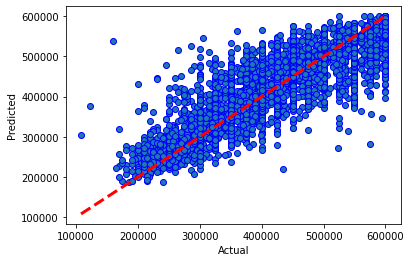

In [57]:
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred, edgecolors=(0, 0, 1))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)
ax.set_ylabel('Predicted')
ax.set_xlabel('Actual')
#ax.title.set_text(f'CV Chosen best option ({calculated_best_pipe[1]})')
plt.show()

In [58]:
if not_catboost:
    def custom_model_and_predictions(model, graph_params, X_train, y_train, X_test):
        graph_model = model
        graph_model.set_params(**graph_params)
        graph_model.fit(X_train, y_train)
        y_pred_graph = model.predict(X_test)

        return model, y_pred_graph


    best_model_count = 10 if not quick_mode else 2
    best_model_count = 3 if not quick_mode else 1
    best_models = {}
    best_model_predictions = {}
    best_model_scores = {}

    showable_increment = total_fits // (4 if not quick_mode else 2)
    for i in range(0, total_fits, showable_increment):
        if debug_mode or True: print(f'{i} ==> {i}')

        if i == 0:
            fitted_graph_model = crossval_runner.best_estimator_
            y_pred_graph = y_pred
        else:
            graph_pipe_params = cv_results_df_sorted['params'][i]
            print(graph_pipe_params)
            # would always return the best! graph_pipe_params = cv_results_df_sorted.loc[cv_results_df_sorted['rank_test_score'] == 1, 'params'].values[0]

            graph_params = {}
            for key, value in graph_pipe_params.items():
                graph_params[key.replace('model__', '')] = value

            fitted_graph_model, y_pred_graph = custom_model_and_predictions(make_pipeline(), graph_pipe_params, X_train,
                                                                            y_train, X_test)

        best_models[i] = fitted_graph_model[-1].get_params()
        best_model_predictions[i] = y_pred_graph
        best_model_scores[i] = fitted_graph_model.score(X_test, y_test)

    if debug_mode or True: print(f'{-1} ==> {-1}')
    graph_pipe_params = cv_results_df_sorted['params'][total_fits - 1]
    print(graph_pipe_params)
    graph_params = {}
    for key, value in graph_pipe_params.items():
        graph_params[key.replace('model__', '')] = value
    fitted_graph_model, y_pred_graph = custom_model_and_predictions(make_pipeline(), graph_pipe_params, X_train,
                                                                    y_train, X_test)
    best_models[-1] = fitted_graph_model[-1].get_params()
    best_model_predictions[-1] = y_pred_graph
    best_model_scores[-1] = fitted_graph_model.score(X_test, y_test)


0 ==> 0
14 ==> 14
{'model__weights': 'distance', 'model__p': 2, 'model__n_neighbors': 21, 'model__n_jobs': 2, 'model__metric': 'minkowski', 'model__leaf_size': 300, 'model__algorithm': 'kd_tree'}
28 ==> 28
{'model__weights': 'uniform', 'model__p': 1, 'model__n_neighbors': 7, 'model__n_jobs': 2, 'model__metric': 'minkowski', 'model__leaf_size': 3000, 'model__algorithm': 'ball_tree'}
42 ==> 42
{'model__weights': 'uniform', 'model__p': 2, 'model__n_neighbors': 7, 'model__n_jobs': -1, 'model__metric': 'minkowski', 'model__leaf_size': 3000, 'model__algorithm': 'kd_tree'}
56 ==> 56
{'model__weights': 'uniform', 'model__p': 2, 'model__n_neighbors': 35, 'model__n_jobs': 1, 'model__metric': 'minkowski', 'model__leaf_size': 3000, 'model__algorithm': 'auto'}
-1 ==> -1
{'model__weights': 'uniform', 'model__p': 2, 'model__n_neighbors': 35, 'model__n_jobs': 1, 'model__metric': 'minkowski', 'model__leaf_size': 3000, 'model__algorithm': 'auto'}


In [59]:
cv_results_df_sorted if not_catboost else ''

,params2,rank_test_score,mean_test_score,mean_fit_time,mean_score_time,params
0,distance/1/13/-1/minkowski/3.3/brute,1,0.691397,0.017916,2.938551,"{'model__weights': 'distance', 'model__p': 1, ..."
1,distance/1/13/2/minkowski/300/brute,1,0.691397,0.008512,2.550701,"{'model__weights': 'distance', 'model__p': 1, ..."
2,distance/1/21/2/minkowski/3.3/ball_tree,3,0.690779,0.046252,3.848867,"{'model__weights': 'distance', 'model__p': 1, ..."
3,distance/1/21/-1/minkowski/300/ball_tree,4,0.690776,0.052639,14.810373,"{'model__weights': 'distance', 'model__p': 1, ..."
4,distance/1/21/-1/minkowski/300/auto,5,0.690775,0.074680,9.539724,"{'model__weights': 'distance', 'model__p': 1, ..."
5,distance/1/21/-1/minkowski/3000/ball_tree,6,0.690772,0.022249,12.601836,"{'model__weights': 'distance', 'model__p': 1, ..."
6,distance/1/9/2/minkowski/3.3/auto,7,0.687686,0.067850,4.711304,"{'model__weights': 'distance', 'model__p': 1, ..."
7,distance/1/35/1/minkowski/3000/ball_tree,8,0.686772,0.016092,6.353733,"{'model__weights': 'distance', 'model__p': 1, ..."
8,distance/1/35/1/minkowski/3000/kd_tree,9,0.686771,0.020819,6.780446,"{'model__weights': 'distance', 'model__p': 1, ..."
9,distance/1/7/2/minkowski/300/auto,10,0.683911,0.036695,5.394703,"{'model__weights': 'distance', 'model__p': 1, ..."


In [60]:
cv_results_df_sorted['params']  if not_catboost and debug_mode else ''

''

In [61]:
cv_results_df_sorted['params'][0] if not_catboost else ''

{'model__weights': 'distance',
 'model__p': 1,
 'model__n_neighbors': 13,
 'model__n_jobs': -1,
 'model__metric': 'minkowski',
 'model__leaf_size': 3.3,
 'model__algorithm': 'brute'}

In [62]:
best_models if not_catboost else ''

{0: {'algorithm': 'brute',
  'leaf_size': 300,
  'metric': 'minkowski',
  'metric_params': None,
  'n_jobs': 2,
  'n_neighbors': 13,
  'p': 1,
  'weights': 'distance'},
 14: {'algorithm': 'kd_tree',
  'leaf_size': 300,
  'metric': 'minkowski',
  'metric_params': None,
  'n_jobs': 2,
  'n_neighbors': 21,
  'p': 2,
  'weights': 'distance'},
 28: {'algorithm': 'ball_tree',
  'leaf_size': 3000,
  'metric': 'minkowski',
  'metric_params': None,
  'n_jobs': 2,
  'n_neighbors': 7,
  'p': 1,
  'weights': 'uniform'},
 42: {'algorithm': 'kd_tree',
  'leaf_size': 3000,
  'metric': 'minkowski',
  'metric_params': None,
  'n_jobs': -1,
  'n_neighbors': 7,
  'p': 2,
  'weights': 'uniform'},
 56: {'algorithm': 'auto',
  'leaf_size': 3000,
  'metric': 'minkowski',
  'metric_params': None,
  'n_jobs': 1,
  'n_neighbors': 35,
  'p': 2,
  'weights': 'uniform'},
 -1: {'algorithm': 'auto',
  'leaf_size': 3000,
  'metric': 'minkowski',
  'metric_params': None,
  'n_jobs': 1,
  'n_neighbors': 35,
  'p': 2,
 

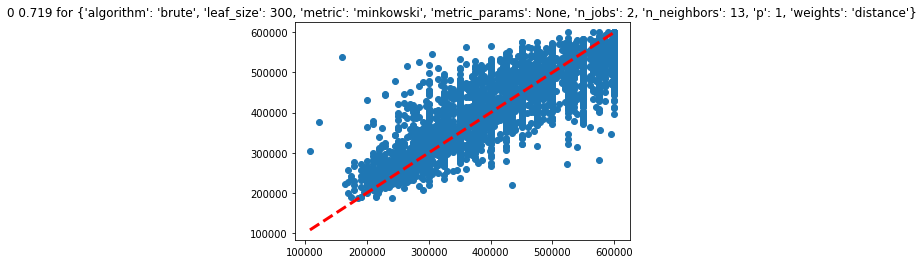

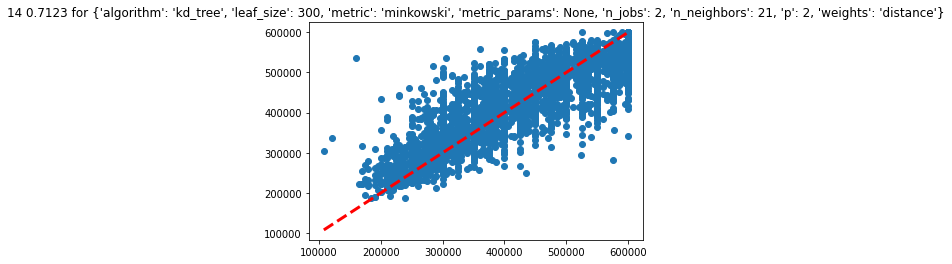

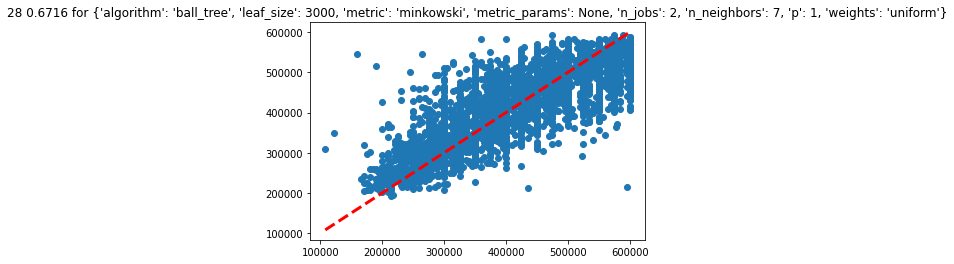

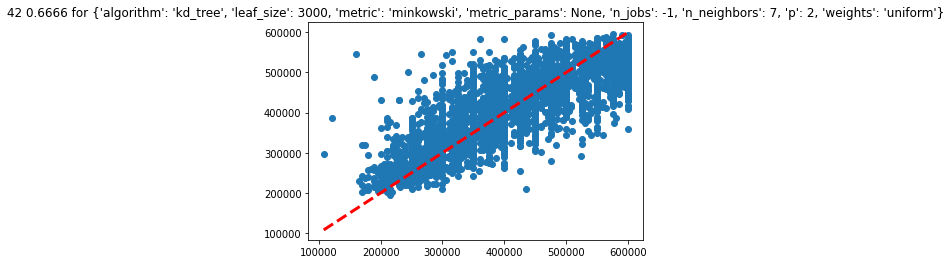

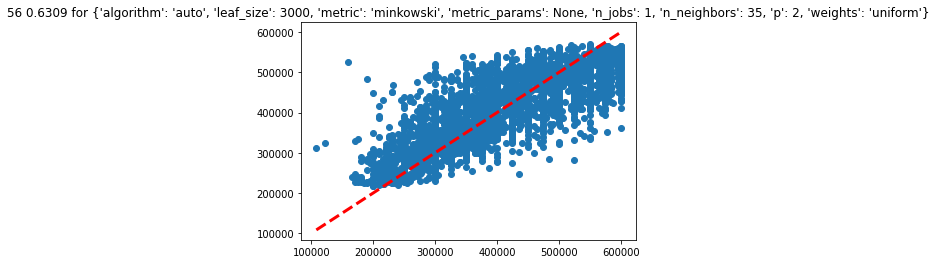

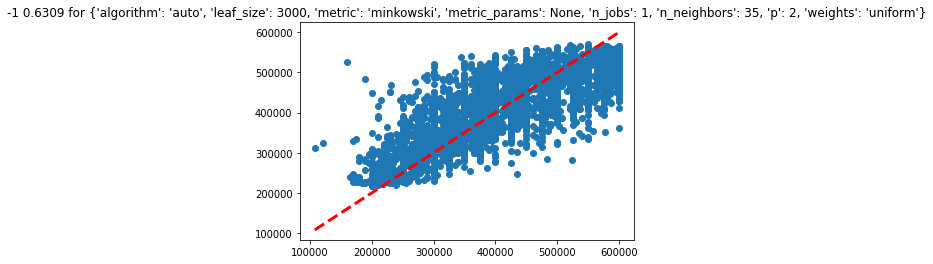

In [63]:
if not_catboost:
    for i in best_model_scores.keys():
        if i >= 0:
            plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)
            plt.scatter(y_test, best_model_predictions[i])
            # plt.title(str(i) + " " + str(round(best_model_scores[i], 4)) + " for " + str(best_models[i]))
            if len(best_models[i].keys()) < 30:
                plt.title(str(i) + " " + str(round(best_model_scores[i], 4)) + " for " + str(best_models[i]))
            else:
                plt.title(str(i) + " " + str(round(best_model_scores[i], 4)) + " for entry " + str(i))
            plt.show()

    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)
    plt.scatter(y_test, best_model_predictions[-1])
    # plt.title(str(i) + " " + str(round(best_model_scores[i], 4)) + " for " + str(best_models[i]))
    if len(best_models[i].keys()) < 30:
        plt.title(str(i) + " " + str(round(best_model_scores[-1], 4)) + " for " + str(best_models[-1]))
    else:
        plt.title(str(i) + " " + str(round(best_model_scores[-1], 4)) + " for (worst) entry " + str(i))

    plt.show()

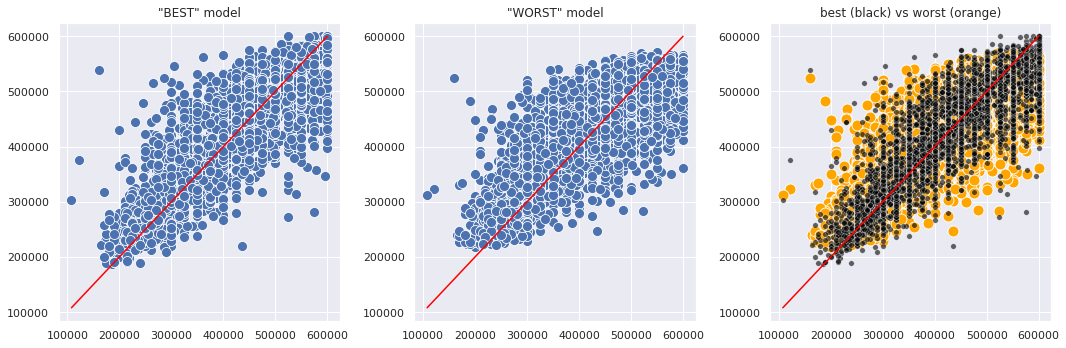

In [64]:
if not_catboost:
    sns.set_theme(font_scale=2, rc=None)
    sns.set_theme(font_scale=1, rc=None)

    fig, axes = plt.subplots(ncols=3, figsize=(15, 5))

    plt.subplots_adjust(hspace=0.2)
    plt.subplots_adjust(wspace=0.2)

    #.flatten()
    coordinates = axes[0]
    sns.lineplot(x=[y_test.min(), y_test.max()], y=[y_test.min(), y_test.max()], ax=axes[0], color='red')
    sns.scatterplot(x=y_test.flatten(), y=best_model_predictions[0].flatten(), ax=axes[0],
                    s=100).set(title=f'"BEST" model')

    sns.lineplot(x=[y_test.min(), y_test.max()], y=[y_test.min(), y_test.max()], ax=axes[1], color='red')
    sns.scatterplot(x=y_test.flatten(), y=best_model_predictions[-1].flatten(), ax=axes[1],
                    s=100).set(title=f'"WORST" model')

    sns.lineplot(x=[y_test.min(), y_test.max()], y=[y_test.min(), y_test.max()], ax=axes[2], color='red')
    sns.scatterplot(x=y_test.flatten(), y=best_model_predictions[-1].flatten(), ax=axes[2],
                    s=120, color='orange')
    sns.scatterplot(x=y_test.flatten(), y=best_model_predictions[0].flatten(), ax=axes[2],
                    s=30, alpha=0.6, color='black').set(
        title='best (black) vs worst (orange)')
    #title='best (orange) vs worst (black)')

    fig.tight_layout()
    plt.show()

In [65]:
if not_catboost:
    cv_best_model_fit_time = cv_results_df_sorted.iloc[0]["mean_fit_time"]
cv_best_model_fit_time if not_catboost else ''

0.017915884653727215

In [66]:
# <catboost.core.CatBoostRegressor object at 0x7fb167387490>
# {'depth': 6}
# defaultdict(<class 'list'>, {'iterations': [0, 1, 2],
# 'test-RMSE-mean': [396884.9605444017, 359548.6632536235, 326027.84885587444],
# 'test-RMSE-std': [308.9495320039113, 260.0967808594464, 219.65856329246023],
# 'train-RMSE-mean': [396884.77936957515, 359542.3612912551, 326018.9404460669],
# 'train-RMSE-std': [91.44140078375503, 86.77961380623475, 69.4038638987425]})

cv_best_model_fit_time = cv_results_df_sorted.iloc[0]["mean_fit_time"] if not_catboost else 999

DD2 = "(" + ",".join(DATA_DETAIL) + ")" if len(DATA_DETAIL) >= 1 else ""
key = f'{ALGORITHM} (v{VERSION})'.lower()

method =  f"{ALGORITHM_DETAIL}{DD2}"

new_results = {
    '_score': score,
    'R square Accuracy': R2,
    'Mean Absolute Error Accuracy': MAE,
    'Mean Squared Error Accuracy': MSE,
    'Root Mean Squared Error': RMSE,
    '_train time': cv_best_model_fit_time,
    'random_state': RANDOM_STATE,
    'date': str(datetime.now()),
    '_params': crossval_runner.best_params_ if not_catboost else cat_params,
    '_method':method,
    'run_env': run_env
}

if run_env not in ['colab']:
    old_results_json = get_results()
    try:
        old_best_score = old_results_json[key]['best score']
    except:
        print(f"haven't scored this model yet: {ALGORITHM}")
        old_best_score = -999
    this_model_is_best = update_results(old_results_json, new_results, key)

print(key)

knn (v06)


In [67]:
crossval_runner.best_estimator_  if not_catboost else ''

Pipeline(steps=[('std_scaler', StandardScaler()),
                ('model',
                 KNeighborsRegressor(algorithm='brute', leaf_size=300, n_jobs=2,
                                     n_neighbors=13, p=1,
                                     weights='distance'))])

In [68]:
if this_model_is_best:
    with open(f'../../../models/optimised_model_{ALGORITHM}_v{VERSION}{DD2}.pkl', 'wb') as f:
        if not_catboost:
            pickle.dump(crossval_runner.best_estimator_, f)
        else:
            pickle.dump(starter_model, f)
        print('pickled new version of model')
        print(f"{old_results_json[key]['_score']} is new best score (it's better than {old_best_score})")
        #print(results_json[key]['_score'], 'is an improvement on', results_json[key]['second best score'])
else:
    print("not updated saved model, the previous run was better")
    print(old_results_json[key]['_score'], 'is worse than or equal to', old_best_score)

# 0.45687994672121157 jh

pickled new version of model
0.7190492600348584 is new best score (it's better than 0.7190492600348584)


In [69]:
if 'tree' in ALGORITHM.lower() or 'forest' in ALGORITHM.lower() or 'boost' in ALGORITHM.lower():
    feature_importances = crossval_runner.best_estimator_[-1].feature_importances_ if not_catboost else starter_model.get_feature_importance()
    #std = np.std([tree.feature_importances_ for tree in model.estimators_], axis = 0)

    indices = np.argsort(feature_importances)[::-1]

    print('Feature Ranking:')

    for f in range(X_train.shape[1]):
        print('%d. features %d (%f)' % (f + 1, indices[f], feature_importances[indices[f]]),
              df_features.columns[indices[f] + 1])
else:
    print(f'{ALGORITHM} does not have feature_importances, skipping')

KNN does not have feature_importances, skipping


In [70]:
if 'tree' in ALGORITHM.lower() or 'forest' in ALGORITHM.lower() or 'boost' in ALGORITHM.lower():
    indices = np.argsort(feature_importances)

    fig, ax = plt.subplots()
    ax.barh(range(len(feature_importances)), feature_importances[indices])
    ax.set_yticks(range(len(feature_importances)))
    _ = ax.set_yticklabels(df_features.columns[[c + 1 for c in indices]])
else:
    print(f'{ALGORITHM} does not have feature_importances, skipping')

KNN does not have feature_importances, skipping
